# _Euro to USD Conversion - Time Series Analysis Project_

In [ ]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import r2_score , mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('BOE-XUDLERD.csv')
df.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


## _Exploratory Data Analysis (EDA)_


In [ ]:
df.shape

(10837, 2)

In [ ]:
df.isnull().sum()

,0
Date,0
Value,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.dtypes

,0
Date,object
Value,float64


In [ ]:
df.describe()

,Value
count,10837.000000
mean,0.864988
std,0.153289
min,0.626000
25%,0.759800
50%,0.826300
75%,0.920300
max,1.551900


## _Data Preprocessing_


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.set_index('Date',inplace = True)

## _Data Processing & Visualization_

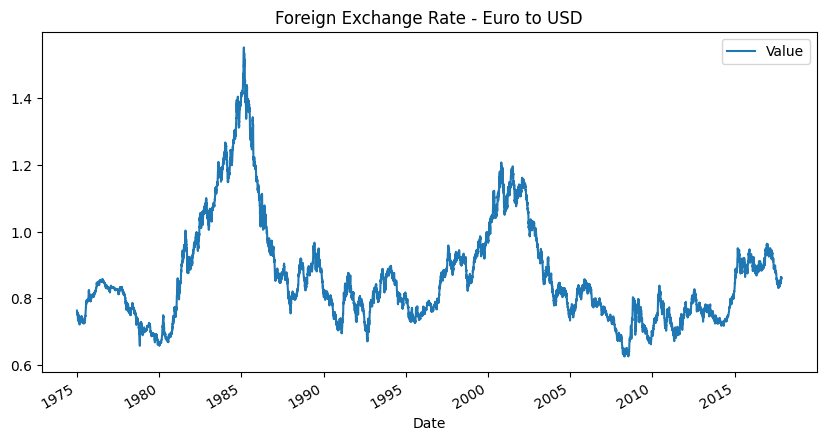

In [ ]:
df.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate - Euro to USD')
plt.show()

In [ ]:
df_week = df.resample('W').mean()
print('Count of The Weekly Data Frame : ',df_week.shape[0])
df_week.head()

Count of The Weekly Data Frame :  2237


,Value
Date,
1975-01-05,0.76090
1975-01-12,0.75346
1975-01-19,0.75546
1975-01-26,0.74388
1975-02-02,0.73902


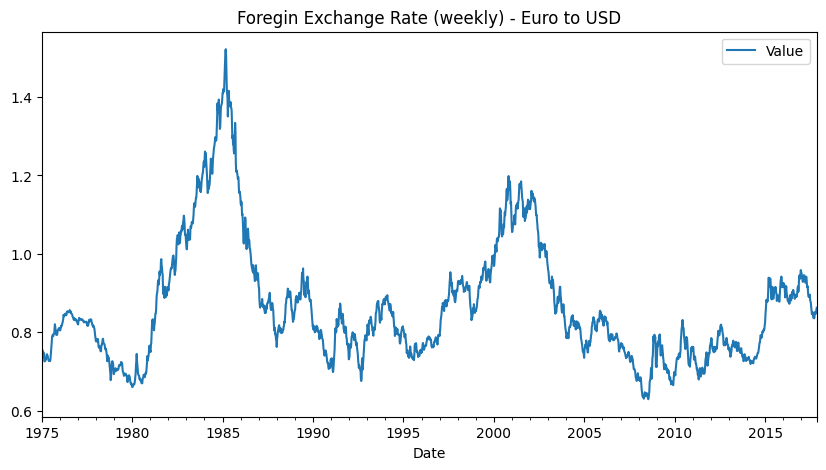

In [ ]:
df_week.plot(figsize = (10,5))
plt.title('Foregin Exchange Rate (weekly) - Euro to USD')
plt.show()

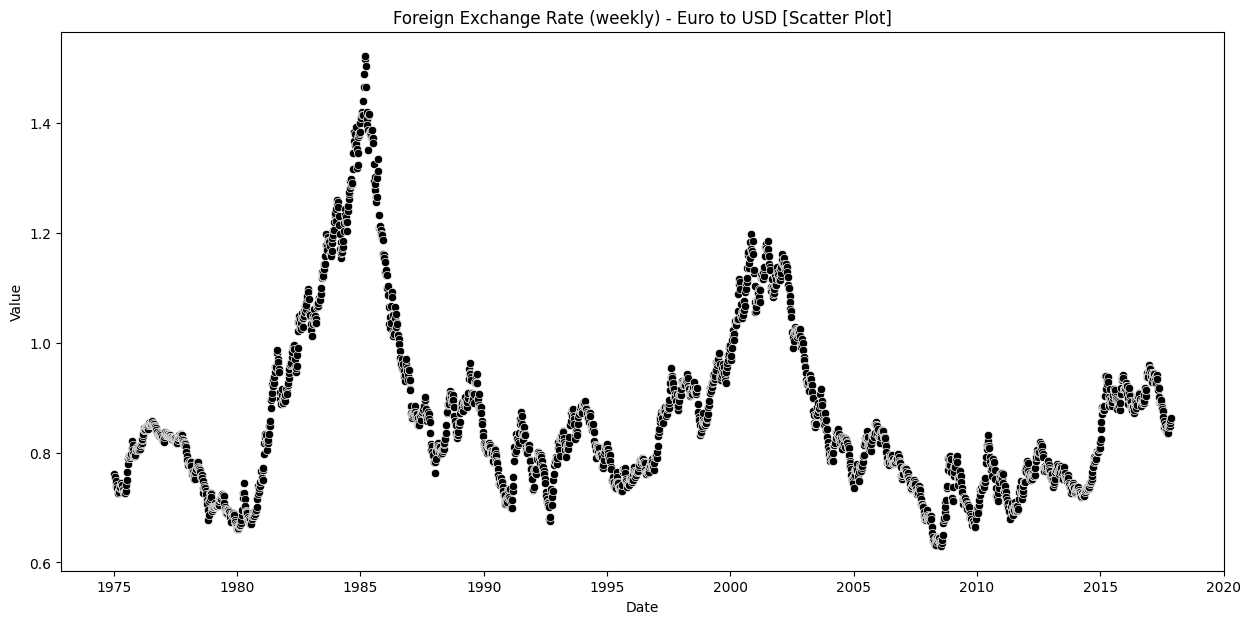

In [ ]:
plt.rcParams['figure.figsize'] = (15,7)
sns.scatterplot(x = df_week.index , y = df_week.Value , color = 'black')
plt.title('Foreign Exchange Rate (weekly) - Euro to USD [Scatter Plot]')
plt.show()

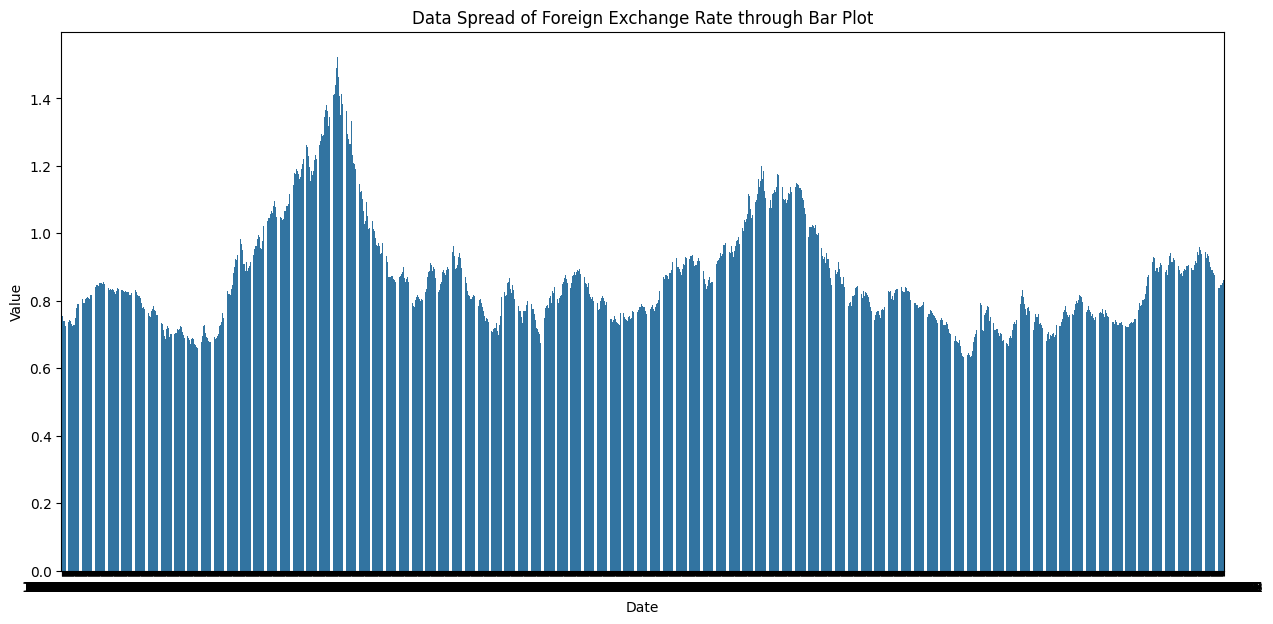

In [ ]:
sns.barplot(data = df_week,x = df_week.index , y = df_week.Value)
plt.title('Data Spread of Foreign Exchange Rate through Bar Plot')
plt.show()

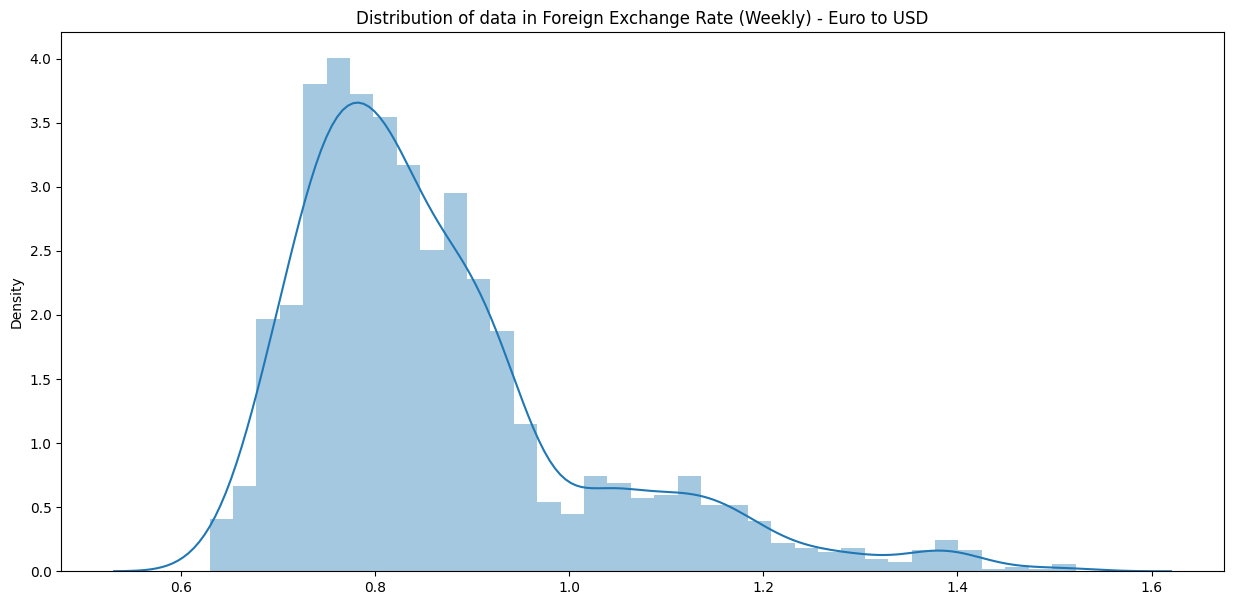

In [ ]:
sns.distplot(df_week)
plt.title('Distribution of data in Foreign Exchange Rate (Weekly) - Euro to USD')
plt.show()

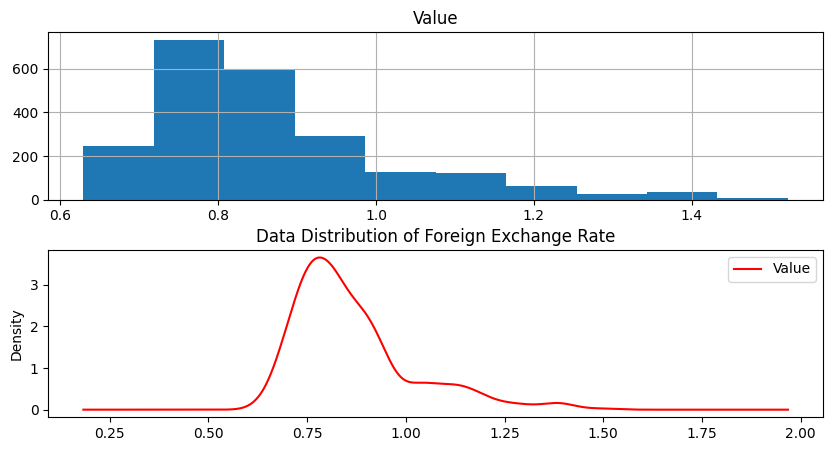

In [ ]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
df_week.hist(ax = ax1)
df_week.plot(kind = 'kde' , ax = ax2,c = 'r')
plt.title('Data Distribution of Foreign Exchange Rate')
plt.show()

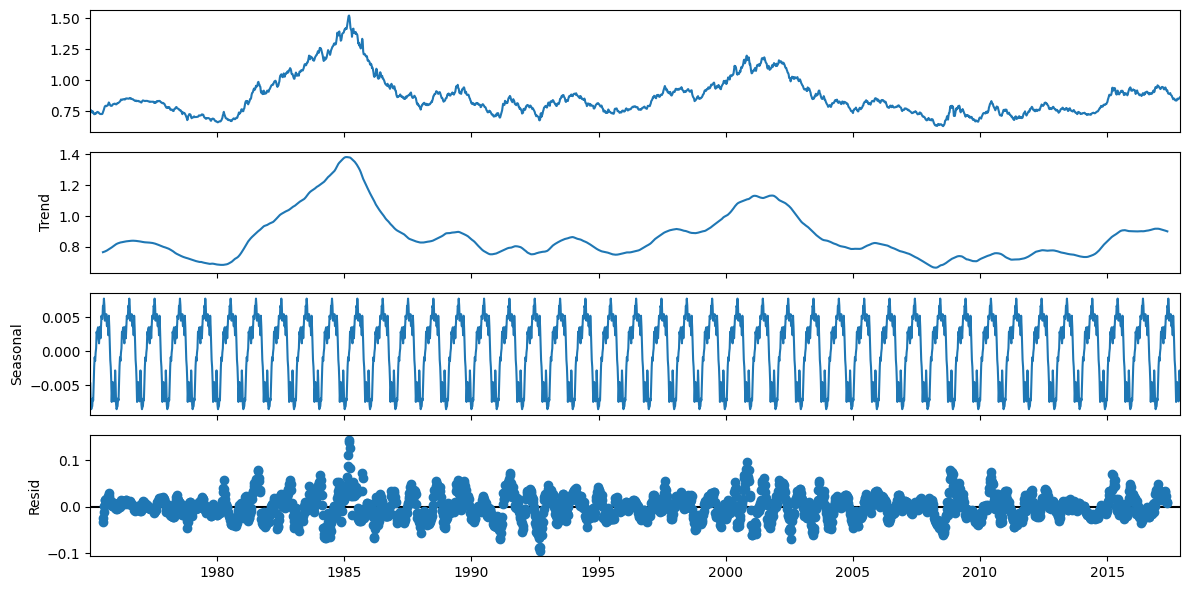

In [ ]:
plt.rcParams['figure.figsize']=(12,6)
decomposition = seasonal_decompose(df_week , period = 52 , model = 'additive')
decomposition.plot()
plt.show()

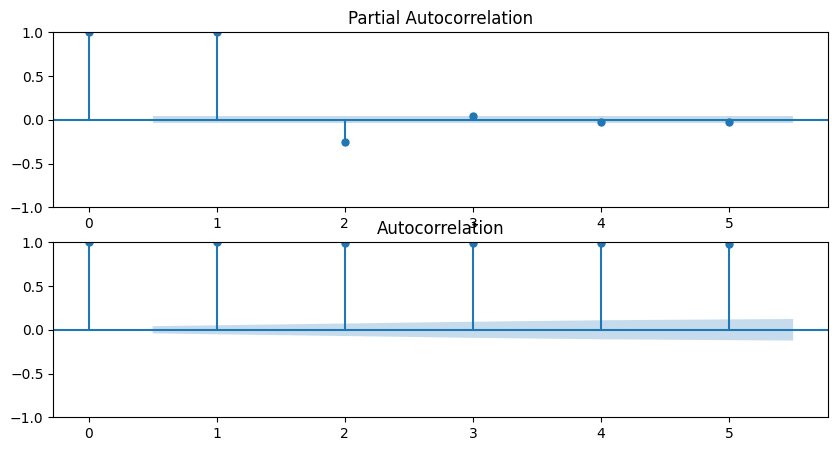

In [ ]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
ax1 = plot_pacf(df_week , lags = 5 , ax = ax1)
ax2 = plot_acf(df_week , lags = 5 , ax = ax2)
plt.savefig('Partial Autocorrelation and Autocorrelation.png')
plt.show()

## _Data Transformation_

**The adf_check() function performs an Augmented Dickey-Fuller test on a time series. The test is used to determine whether a time series is stationary or not.**

In [ ]:
def adf_check(time_series):
    result = adfuller(time_series , autolag = 'AIC')
    label = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        label['Critical Value (%s)'%key] = value
    print(label)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary')
    else:
        print ('Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary ')

In [ ]:
adf_check(df_week)

Test Statistic                   -2.076341
p-value                           0.254134
Number of Lags Used               2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary 


In [ ]:
df1_week = df_week.diff().dropna()
print('Count of weekly First Difference',df1_week.shape[0])
df1_week.head()

Count of weekly First Difference 2236


,Value
Date,
1975-01-12,-0.00744
1975-01-19,0.00200
1975-01-26,-0.01158
1975-02-02,-0.00486
1975-02-09,0.01004


In [ ]:
adf_check(df1_week)

Test Statistic                  -30.128987
p-value                           0.000000
Number of Lags Used               1.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary


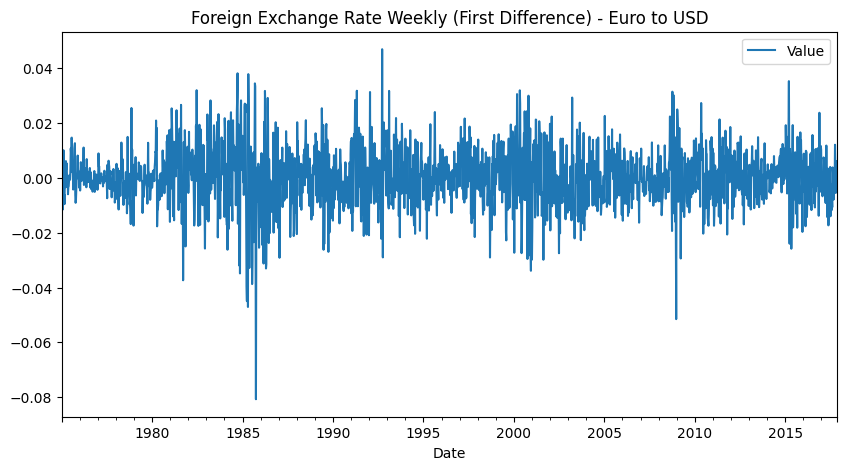

In [ ]:
df1_week.plot(figsize = (10,5))
plt.title('Foreign Exchange Rate Weekly (First Difference) - Euro to USD')
plt.show()

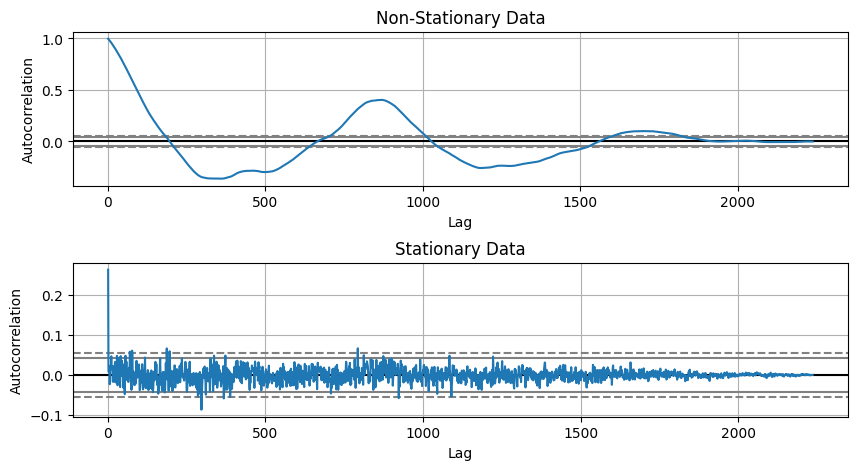

In [ ]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
ax1 = autocorrelation_plot(df_week , ax = ax1)
ax1.set_title('Non-Stationary Data')
ax2 = autocorrelation_plot(df1_week , ax = ax2)
ax2.set_title('Stationary Data')
plt.subplots_adjust(hspace = 0.5)
plt.show()

## _Model Fitting_
**_Getting the p value and q value for the model fitting using `auto_arima` function by passing through some needed parameters , the best model is evaluated by least Akaike Information Criterion (AIC)_**

In [ ]:
model = auto_arima(df_week , m = 52, d = 1 ,seasonal = False , max_order = 8 , test = 'adf' , trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14195.726, Time=4.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14039.528, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14196.131, Time=2.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14200.250, Time=4.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14041.486, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14199.705, Time=4.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14199.738, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14197.726, Time=1.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14202.222, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14201.680, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-14201.713, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-14198.107, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-14199.700, Time=0.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 22.156 sec

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2237
Model:               SARIMAX(0, 1, 1)   Log Likelihood                7103.111
Date:                Thu, 10 Oct 2024   AIC                         -14202.222
Time:                        12:52:56   BIC                         -14190.797
Sample:                    01-05-1975   HQIC                        -14198.051
                         - 11-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2755      0.015     18.107      0.000       0.246       0.305
sigma2         0.0001   2.03e-06     50.197      0.000    9.79e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               635.74
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = ARIMA(df_week , order = (0,1,1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                 2237
Model:                 ARIMA(0, 1, 1)   Log Likelihood                7103.111
Date:                Thu, 10 Oct 2024   AIC                         -14202.222
Time:                        12:53:02   BIC                         -14190.797
Sample:                    01-05-1975   HQIC                        -14198.051
                         - 11-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2755      0.015     18.107      0.000       0.246       0.305
sigma2         0.0001   2.03e-06     50.197      0.000    9.79e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               635.74
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions = result.predict(typ = 'levels')

## _Model Evaluation_
**_Evaluating the model with the following metrics such as percentage of r2 score , mean squared error , root mean squared error , mean absolute error and mean absolute percentage error for the predicted value and whole data value._**

In [ ]:
print('Evaluation Result for whole data : ','\n')
print('R2 Score for whole data : {0:.2f} %'.format(100*r2_score(df_week['Value'],predictions)),'\n')
print('Mean Squared Error : ',mean_squared_error(df_week['Value'],predictions),'\n')
print('Mean Absolute Error : ',mean_absolute_error(df_week['Value'],predictions),'\n')
print('Root Mean Squared Error : ',sqrt(mean_squared_error(df_week['Value'],predictions)),'\n')

Evaluation Result for whole data :  

R2 Score for whole data : 98.46 % 

Mean Squared Error :  0.00036069121331298756 

Mean Absolute Error :  0.007796562268749338 

Root Mean Squared Error :  0.01899187229614257 



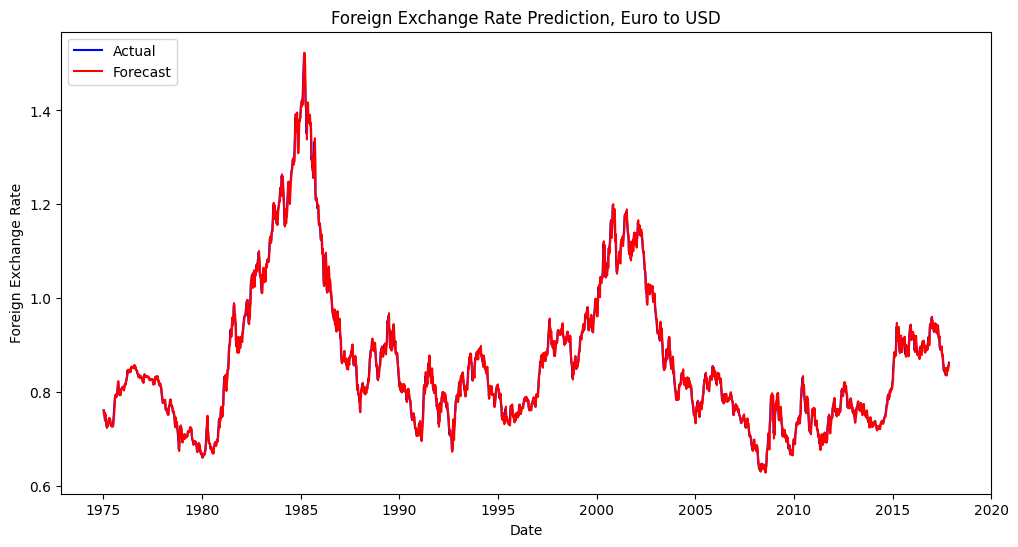

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)

# Create a plot
fig, ax = plt.subplots()

# Plot the actual data
ax.plot(df_week, label='Actual', color='blue')  # Actual data in blue

# Plot the predictions
ax.plot(predictions[1:], label='Forecast', color='red')  # Forecast data in red

# Add titles and labels
ax.set_title('Foreign Exchange Rate Prediction, Euro to USD')
ax.set_xlabel('Date')
ax.set_ylabel('Foreign Exchange Rate')

# Add a legend
ax.legend(loc='upper left')

# Show the plot
plt.show()

# **LSTM**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Prepare the data
data = df['Value'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Create sequences
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# Set the time step
time_step = 3
X, y = create_dataset(scaled_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 2.2755e-04
Epoch 2/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 1.7814e-04
Epoch 3/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 1.3800e-04
Epoch 4/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.1866e-04
Epoch 5/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 1.0038e-04
Epoch 6/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 8.5844e-05
Epoch 7/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 7.4876e-05
Epoch 8/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 7.7303e-05
Epoch 9/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 7.7309e-05
Epoch 10/10
8666/8666 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 7.0594e-05


In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Prepare the plot data
# Combine train and test predictions for a continuous line
combined_predictions = np.concatenate((train_predict.flatten(), test_predict.flatten()))
combined_predictions.shape
# Create a continuous x-axis for predictions
pred_x = np.arange(time_step, len(combined_predictions) + time_step)
pred_x.shape

(10833,)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Reshape y_test to a 2D array before inverse transforming
y_test_2d = y_test.reshape(-1, 1)  # Reshape to 2D

# Calculate RMSE using only the test data and predictions
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test_2d), test_predict))

# Calculate MAE - already correct
mae = mean_absolute_error(scaler.inverse_transform(y_test_2d), test_predict)

# Calculate MAPE - already correct
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test_2d), test_predict)

# Print the results
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.004874639481078872
MAE: 0.003468571543682539


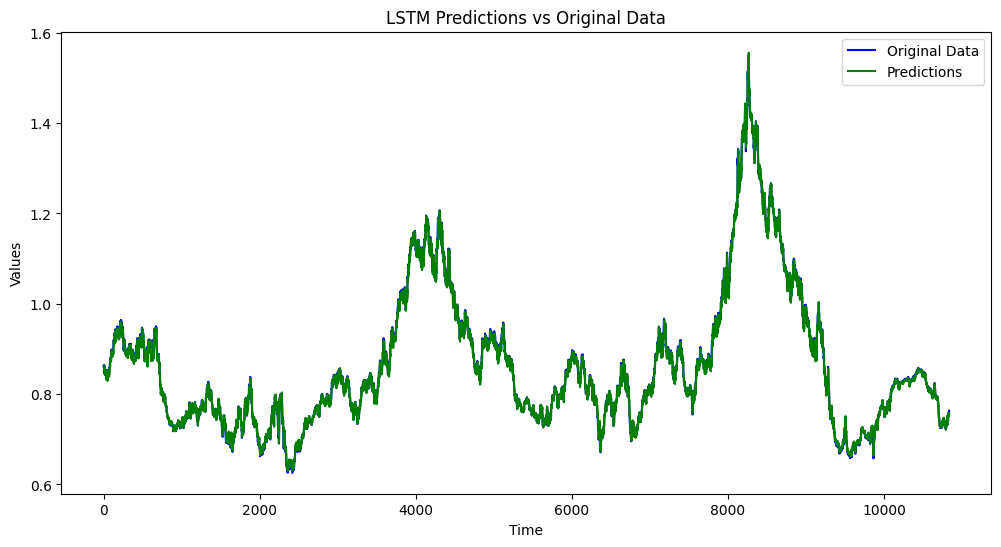

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data', color='blue')
plt.plot(pred_x, combined_predictions, label='Predictions', color='green')

plt.title('LSTM Predictions vs Original Data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# **GARCH**

In [ ]:
! pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 11.8 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
# Define the range of p and q (orders of GARCH model) to experiment with
p_values = range(1, 4)
q_values = range(1, 4)

# Prepare to store results
best_aic = np.inf
best_order = None
best_model = None

# Loop through different combinations of p and q
for p in p_values:
    for q in q_values:
        try:
            # Fit the GARCH model
            model = arch_model(df['Value'].dropna(), vol='Garch', p=p, q=q)
            model_fit = model.fit(disp='off')

            # Print the current order and AIC
            print(f'GARCH({p}, {q}) - AIC: {model_fit.aic}')

            # Find the best model based on AIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
                best_model = model_fit
        except Exception as e:
            print(f'Error fitting GARCH({p}, {q}): {e}')

# Print the best model's order and AIC
print(f'\nBest GARCH model: GARCH{best_order} - AIC: {best_aic}')

GARCH(1, 1) - AIC: -23474.860542972485
GARCH(1, 2) - AIC: -23476.3416854311
GARCH(1, 3) - AIC: -23364.88984087213
GARCH(2, 1) - AIC: -23453.51609599445
GARCH(2, 2) - AIC: -23399.171237207334
GARCH(2, 3) - AIC: -23345.997362089038
GARCH(3, 1) - AIC: -23433.906098830164
GARCH(3, 2) - AIC: -23382.770709000757
GARCH(3, 3) - AIC: -23323.860822259743

Best GARCH model: GARCH(1, 2) - AIC: -23476.3416854311


In [ ]:
# Print the summary of the best GARCH model
print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Value   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11743.2
Distribution:                  Normal   AIC:                          -23476.3
Method:            Maximum Likelihood   BIC:                          -23439.9
                                        No. Observations:                10837
Date:                Thu, Oct 10 2024   Df Residuals:                    10836
Time:                        07:06:01   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.8048  1.593e-03    505.320      0.000 [  0.802,  0.80

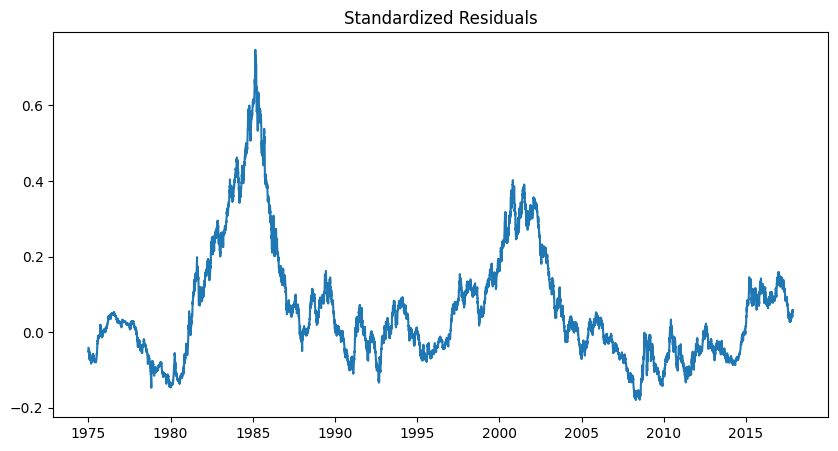

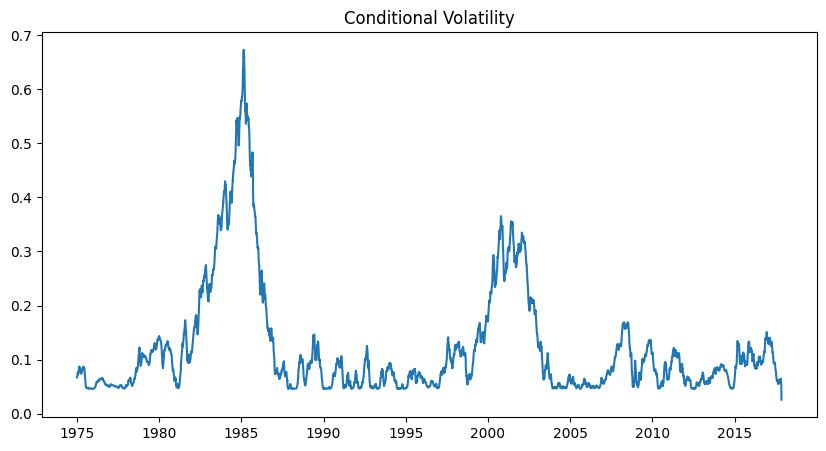

In [ ]:
# Plot standardized residuals
plt.figure(figsize=(10, 5))
plt.plot(best_model.resid)
plt.title('Standardized Residuals')
plt.show()

# Plot conditional volatility
plt.figure(figsize=(10, 5))
plt.plot(best_model.conditional_volatility)
plt.title('Conditional Volatility')
plt.show()

h.01    0.004364
h.02    0.004787
h.03    0.004979
h.04    0.005257
h.05    0.005495
h.06    0.005743
h.07    0.005981
h.08    0.006218
h.09    0.006449
h.10    0.006677
Name: 1975-01-02 00:00:00, dtype: float64


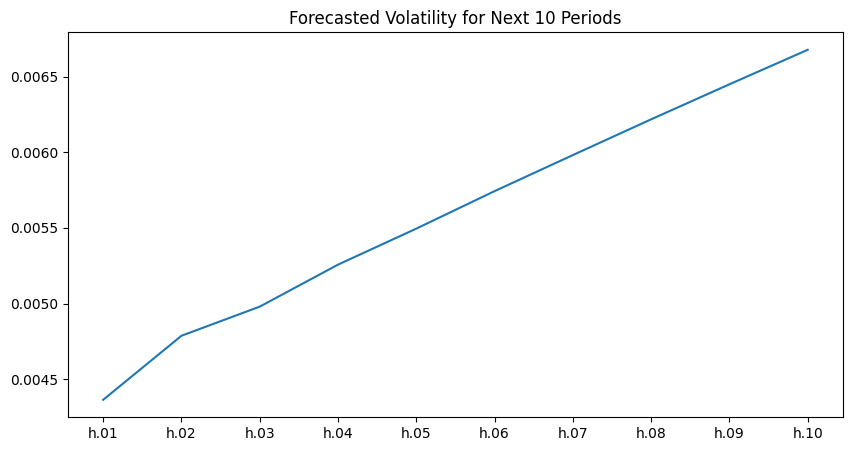

In [ ]:
# Forecast the next 10 periods
forecast = best_model.forecast(horizon=10)

# Extract the forecasted variance (volatility)
forecasted_variance = forecast.variance.iloc[-1]
print(forecasted_variance)

# Plot the forecasted variance
plt.figure(figsize=(10, 5))
plt.plot(forecasted_variance)
plt.title('Forecasted Volatility for Next 10 Periods')
plt.show()

In [ ]:
# Define the size for training set (80%)
size = int(len(df) * 0.80)

# Split the data
train = df['Value'][:size]
test = df['Value'][size:]

print('Training set size:', train)
print('Testing set size:', test)

Training set size: Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
               ...  
1983-08-03    1.1751
1983-08-02    1.1749
1983-08-01    1.1811
1983-07-29    1.1677
1983-07-28    1.1594
Name: Value, Length: 8669, dtype: float64
Testing set size: Date
1983-07-27    1.1577
1983-07-26    1.1526
1983-07-25    1.1528
1983-07-22    1.1449
1983-07-21    1.1397
               ...  
1975-01-08    0.7554
1975-01-07    0.7510
1975-01-06    0.7524
1975-01-03    0.7585
1975-01-02    0.7633
Name: Value, Length: 2168, dtype: float64


In [ ]:
# Fit the GARCH model on the training set
model = arch_model(train, vol='Garch', p=1, q=2)  # You can change p and q as needed
model_fit = model.fit(disp='off')

# Print the model summary
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Value   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9188.54
Distribution:                  Normal   AIC:                          -18367.1
Method:            Maximum Likelihood   BIC:                          -18331.7
                                        No. Observations:                 8669
Date:                Thu, Oct 10 2024   Df Residuals:                     8668
Time:                        07:10:27   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.8047  1.868e-03    430.722      0.000 [  0.801,  0.80

In [ ]:
# Forecast the next n steps (length of test set)
n_steps = len(test)
forecast = model_fit.forecast(horizon=n_steps)

# Get the predicted variance (volatility)
predicted_volatility = np.sqrt(forecast.variance.values[-1, :])  # Extract the last forecasted variance

In [ ]:
# Calculate the MSE for the predictions
mse = mean_squared_error(test, predicted_volatility)
print(f'Mean Squared Error: {mse}')

In [ ]:
# Plot actual vs predicted volatility
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual Returns', color='blue')
plt.plot(test.index, predicted_volatility, label='Predicted Volatility', color='red')
plt.title('Actual vs Predicted Volatility')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Value   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -85479.8
Distribution:                  Normal   AIC:                           170968.
Method:            Maximum Likelihood   BIC:                           170997.
                                        No. Observations:                10836
Date:                Thu, Oct 10 2024   Df Residuals:                    10835
Time:                        18:08:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             1.6054      0.826      1.943  5.197e-02 [-1.37

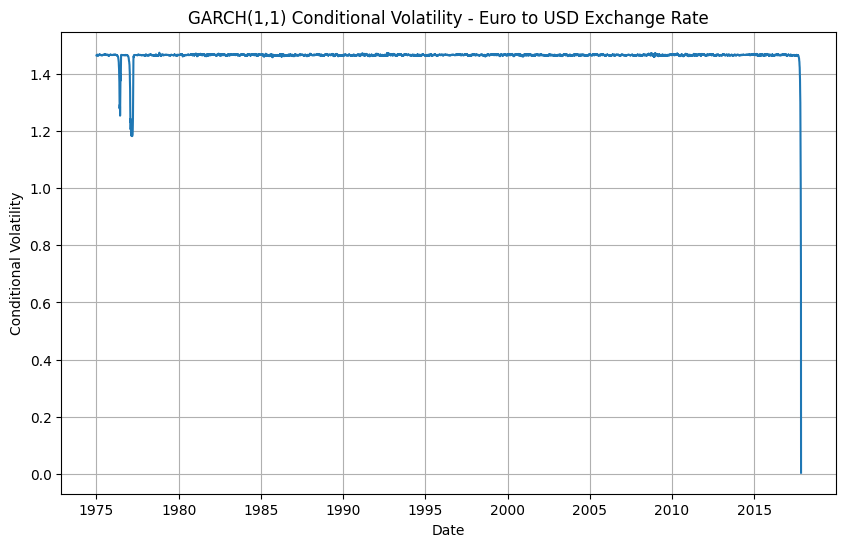

In [ ]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('BOE-XUDLERD.csv')

# Convert the 'Date' column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate the percentage returns and drop any missing values
returns = df['Value'].pct_change().dropna()

# Define and fit the GARCH(1,1) model
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp='off')

# Print the model summary
print(garch_fitted.summary())

# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(garch_fitted.conditional_volatility)
plt.title('GARCH(1,1) Conditional Volatility - Euro to USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

# Exponential Smoothing

In [ ]:
! pip install statsmodels

In [ ]:
from statsmodels.tsa.holtwinters import Holt

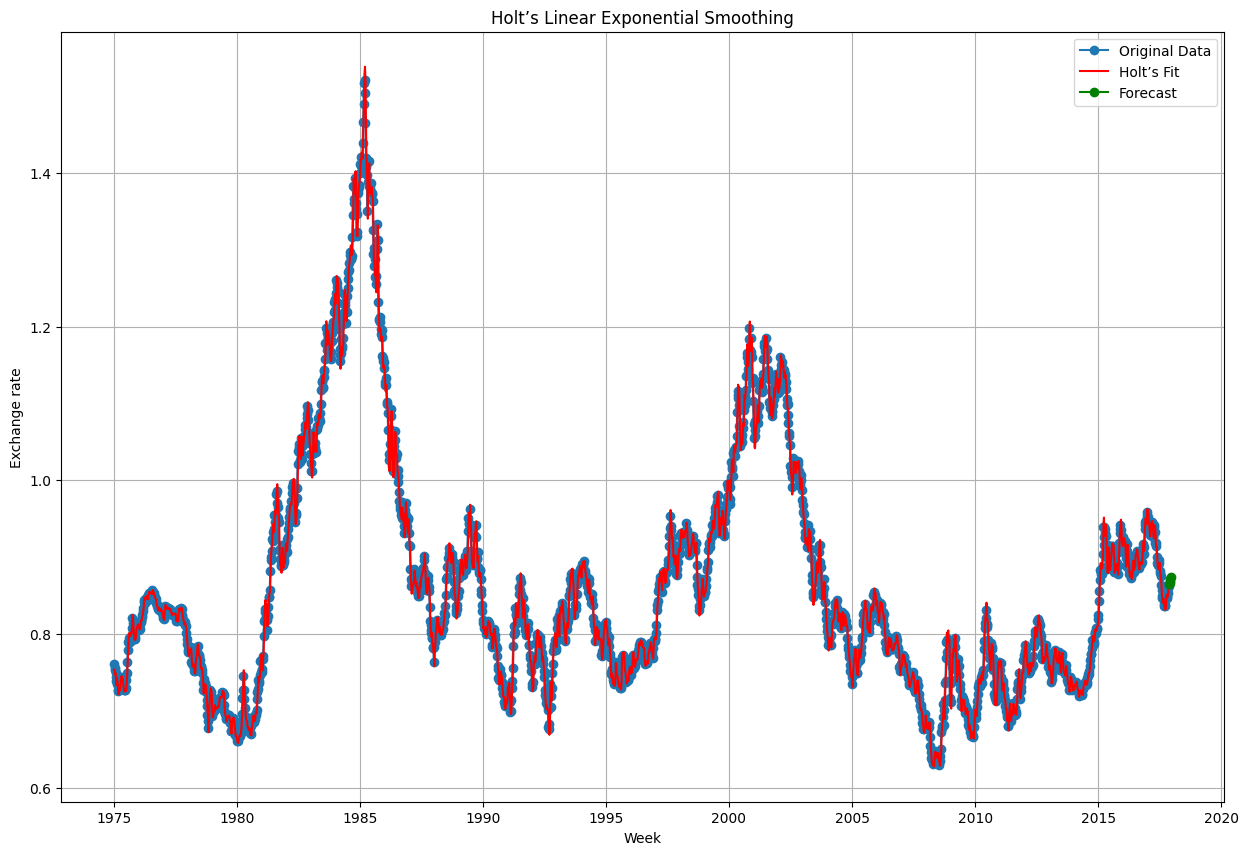

In [ ]:
# Fit Holt's model
holt_model = Holt(df_week['Value']).fit(smoothing_level=0.8, smoothing_slope=0.2)

# Forecasting the next periods (e.g., 5 years ahead)
forecast_periods = 5
forecast = holt_model.forecast(steps=forecast_periods)

# Plotting the original data and the fitted values
plt.figure(figsize=(15, 10))
plt.plot(df_week['Value'], label='Original Data', marker='o')
plt.plot(holt_model.fittedvalues, label='Holt’s Fit', color='red')
plt.plot(forecast.index, forecast, label='Forecast', color='green', marker='o')
plt.title('Holt’s Linear Exponential Smoothing')
plt.xlabel('Week')
plt.ylabel('Exchange rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Calculate RMSE
rmse_exp = np.sqrt(mean_squared_error(df_week['Value'], holt_model.fittedvalues))

# Calculate MAE
mae_exp = mean_absolute_error(df_week['Value'], holt_model.fittedvalues)

# Calculate MAPE
mape_exp = mean_absolute_percentage_error(df_week['Value'], holt_model.fittedvalues)

# Print the results
print(f'RMSE: {rmse_exp}')
print(f'MAE: {mae_exp}')
print(f'MAPE: {mape_exp * 100}%')

RMSE: 0.011331897465926931
MAE: 0.008318344314084672
MAPE: 0.9450474833862592%
